In [204]:
import os
import torch
import torchvision
from transformers import DetrForObjectDetection, DetrImageProcessor
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm
import numpy as np
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont

In [107]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = "facebook/detr-resnet-50"

In [167]:
detr_model = DetrForObjectDetection.from_pretrained(CHECKPOINT, num_labels=1, revision="no_timm", ignore_mismatched_sizes=True)
detr_model

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

# Coco Data Loader

In [269]:
class InBreastDataset(torchvision.datasets.CocoDetection):
    def __init__(self, images_path: str, processor):
        annotation_file_path = os.path.join(images_path, ANNOTATION_FILE_NAME)
        super().__init__(images_path, annotation_file_path)
        self.processor = processor

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        image_id = self.ids[idx]
        target  = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        labels = encoding["labels"][0]
        return pixel_values, labels


# settings
DATASET = 'InBreast_Coco'
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(DATASET, "train")
VAL_DIRECTORY = os.path.join(DATASET, "valid")
TEST_DIRECTORY = os.path.join(DATASET, "test")

processor = DetrImageProcessor.from_pretrained(CHECKPOINT)

train_dataset = InBreastDataset(images_path=TRAIN_DIRECTORY, processor=processor)
val_dataset = InBreastDataset(images_path=VAL_DIRECTORY, processor=processor)
test_dataset = InBreastDataset(images_path=TEST_DIRECTORY, processor=processor)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [262]:
pixel_values, labels = train_dataset.__getitem__(0)
print(pixel_values.shape)
print(labels)

torch.Size([3, 800, 800])
{'size': tensor([800, 800]), 'image_id': tensor([0]), 'class_labels': tensor([0]), 'boxes': tensor([[0.2477, 0.3613, 0.1734, 0.1383]]), 'area': tensor([15349.2188]), 'iscrowd': tensor([0]), 'orig_size': tensor([640, 640])}


In [263]:
labels

{'size': tensor([800, 800]), 'image_id': tensor([0]), 'class_labels': tensor([0]), 'boxes': tensor([[0.2477, 0.3613, 0.1734, 0.1383]]), 'area': tensor([15349.2188]), 'iscrowd': tensor([0]), 'orig_size': tensor([640, 640])}

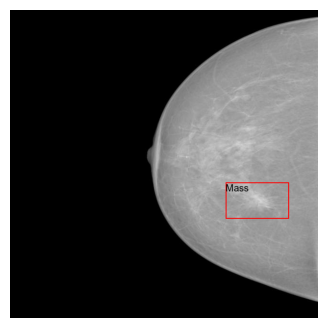

In [264]:
pixel_values, labels = val_dataset.__getitem__(0)
image_id = labels['image_id'].item()
image_data = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(VAL_DIRECTORY, image_data['file_name']))
annotations = val_dataset.coco.imgToAnns[image_id]

draw = ImageDraw.Draw(image, "RGB")

categories = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

for annotation in annotations:
    box = annotation['bbox']
    class_idx = annotation['category_id']
    x,y,w,h = tuple(box)
    draw.rectangle((x,y,x+w,y+h), outline='red', width=2)
    draw.text((x, y), id2label[class_idx], fill='black', 
              font=ImageFont.truetype("arial.ttf", 20))

plt.figure(figsize=(4,4))
plt.axis("off")
plt.imshow(image)

In [283]:
def collate_fn(batch):
    pixel_values = torch.stack([item[0] for item in batch])
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = pixel_values
    batch['labels'] = labels
    return batch
  

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=16)

In [284]:
class Detr(pl.LightningModule):
    def __init__(self, detr_model, lr, lr_backbone, weight_decay):
        super().__init__()
        self.detr_model = detr_model
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values):
        outputs = self.detr_model(pixel_values)
        return outputs

    def training_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        labels = batch['labels']
        outputs = self.detr_model(pixel_values=pixel_values, labels=labels)
        self.log("train_loss", outputs.loss)
        for loss_name, loss in outputs.loss_dict.items():
            self.log(f"train_{loss_name}", loss.item())
        return outputs.loss
     
    def validation_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        labels = batch['labels']
        outputs = self.detr_model(pixel_values=pixel_values, labels=labels)
        self.log("valid_loss", outputs.loss)
        for loss_name, loss in outputs.loss_dict.items():
            self.log(f"valid_{loss_name}", loss.item())
        return outputs.loss

    def configure_optimizers(self):
        param_dicts = [
            { 
                "params": [
                    p for n, p in self.named_parameters()
                    if "backbone" not in n and p.requires_grad
                ]
            },
            {
                "params": [
                    p for n, p in self.named_parameters() 
                    if "backbone" in n and p.requires_grad
                ],
                "lr": self.lr_backbone
            }
        ]
        print(self.named_parameters())
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)
        return optimizer
        
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4, detr_model=detr_model)


In [ ]:
trainer = Trainer(max_steps=500, log_every_n_steps=5)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

# Inference

In [287]:
def plot_results(image, scores, labels, boxes):
    draw = ImageDraw.Draw(image, "RGBA")

    for score, label, (x, y, xf, yf) in zip(scores.tolist(), labels.tolist(), boxes.tolist()):
        draw.rectangle((x, y, xf, yf), outline='red', width=2)
        text = f'{np.round(score, 2)} - {id2label[label]}'
        draw.text((x, y), text, fill='black', 
                  font=ImageFont.truetype("arial.ttf", 20))

    plt.figure(figsize=(4,4))
    plt.axis("off")
    plt.imshow(image)

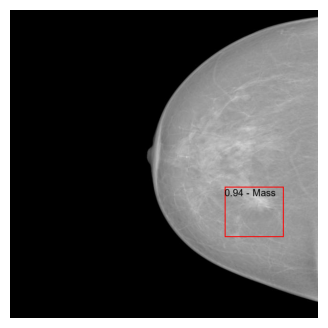

In [293]:
pixel_values, labels = val_dataset.__getitem__(0)
image_id = labels['image_id'].item()
image_data = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(VAL_DIRECTORY, image_data['file_name']))

with torch.no_grad():
    model.eval()
    outputs = model(pixel_values=pixel_values.unsqueeze(0))

postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(640, 640)],
                                                                threshold=0.9)
results = postprocessed_outputs[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])